# Visualization of uncertainty quantification in Matplotlib or OpenTURNS

## Introduction
Matplotlib is a Python plotting library which can manage Numpy arrays. OpenTURNS is a library for uncertainty quantification (UQ) which provides graphical features. The goal of this Notebook is to show how we may create UQ plots _if OpenTURNS did not provide this feature_. 

The method is as follows. For some classical plots, we provide two ways to produce the result:
- with the built-in graphical feature from OpenTURNS,
- with Matplotlib.

Actually, OpenTURNS _does_ use Matplotlib as its backend.

We consider the following plots:
- PDF of a distribution,
- plot a (X, Y) sample from a function,
- cross-cuts of a function,
- contour of the PDF of a distribution,
- Sobol' indices of a function.

March 2025

_Joseph Muré_, _Michaël Baudin_

In [1]:
import openturns as ot
import pylab as pl
import numpy as np
from openturns.usecases.wingweight_function import WingWeightModel
import openturns.viewer as otv
import matplotlib as mpl
from openturns.usecases import ishigami_function
import matplotlib.ticker as mticker

## PDF of a distribution

### Using OpenTURNS only

In [2]:
distribution = ot.Normal()

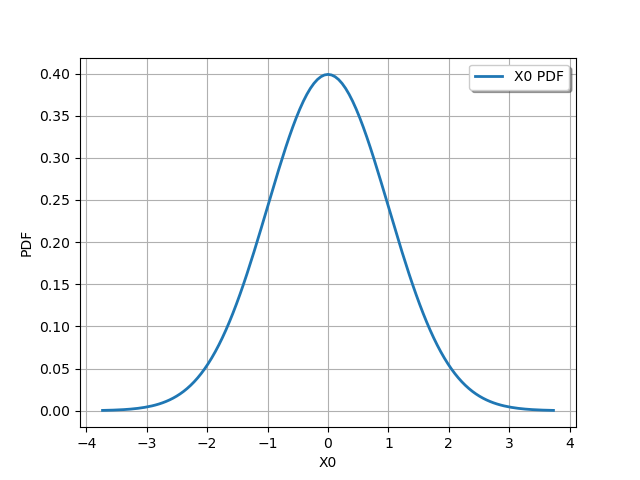

In [3]:
distribution.drawPDF()  # <-- This is the tested feature

### Using Matplotlib, if OpenTURNS had no drawPDF()

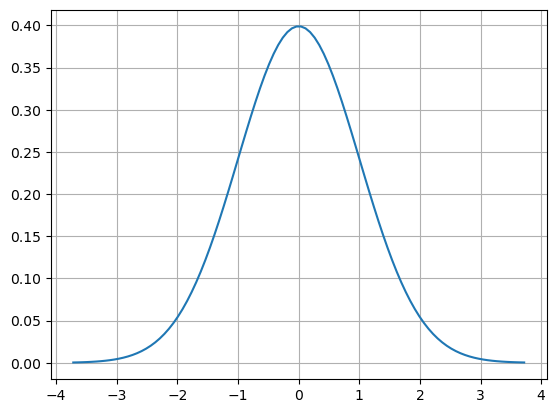

In [4]:
distribution = ot.Normal()
p = 1.0e-4
x_min = distribution.computeQuantile(p)
x_max = distribution.computeQuantile(p, True)
n_points = 100
x_values = np.linspace(x_min, x_max, n_points)
y_values = [distribution.computePDF(x) for x in x_values]
_ = pl.figure()
_ = pl.plot(x_values, y_values)
# pl.xlabel("X0")  # Not strictly necessary
# pl.ylabel("PDF")
# pl.legend(["X0 PDF"])
pl.grid()

## Plot a (X, Y) sample from a function

### Using OpenTURNS only

We could use 
```python
from openturns.usecases import ishigami_function
im = ishigami_function.IshigamiModel()
```
but let us assume that we are interested in a brand new function.


In [5]:
def ishigami(x):
    x1, x2, x3 = x
    y = np.sin(x1) + 7.0 * np.sin(x2) ** 2 + 0.1 * x3**4 * np.sin(x1)
    return [y]


ishigami_g = ot.PythonFunction(3, 1, ishigami)
input_distribution = ot.JointDistribution([ot.Uniform(-np.pi, np.pi)] * 3)
input_sample = input_distribution.getSample(1000)
output_sample = ishigami_g(input_sample)

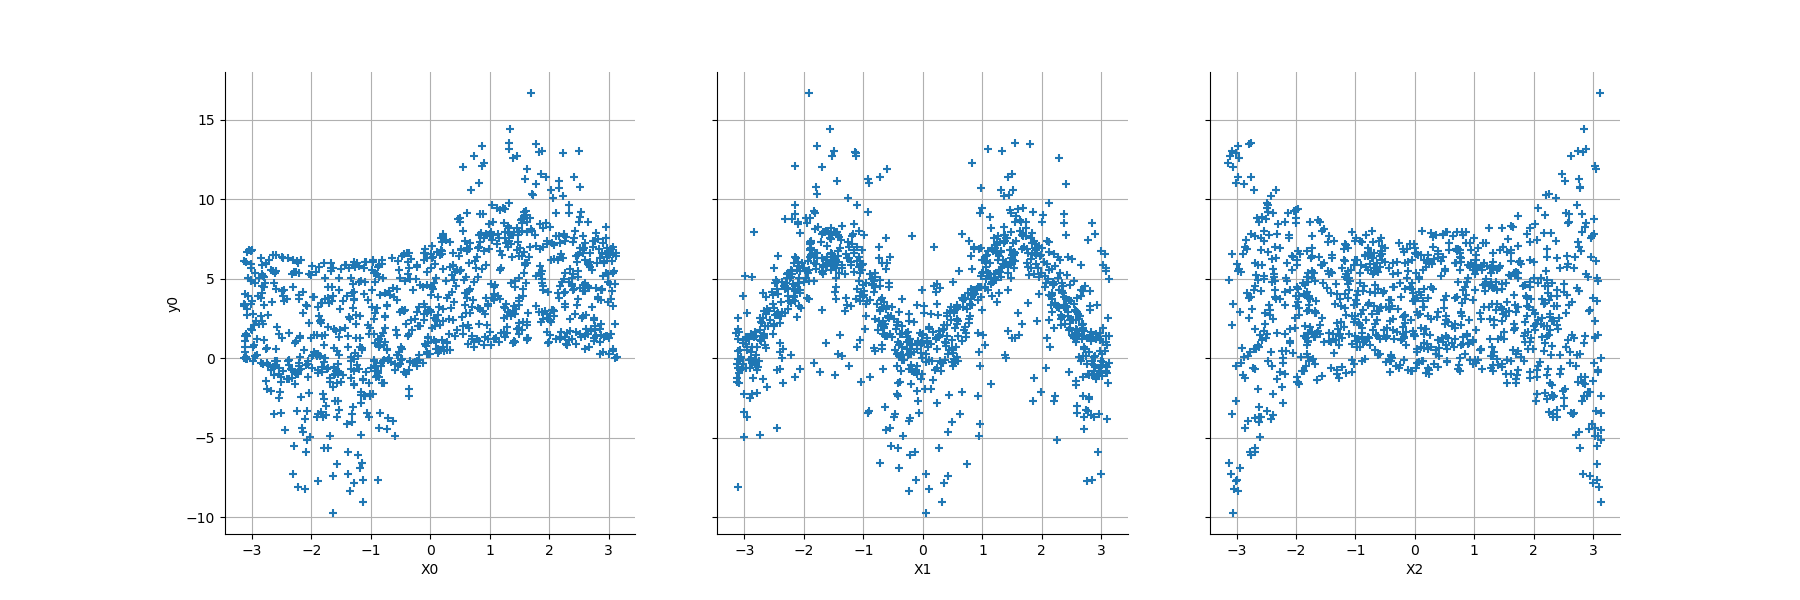

In [6]:
ot.VisualTest.DrawPairsXY(input_sample, output_sample)  # <-- This is the tested feature

### Using Matplotlib, if OpenTURNS had no DrawPairsXY()

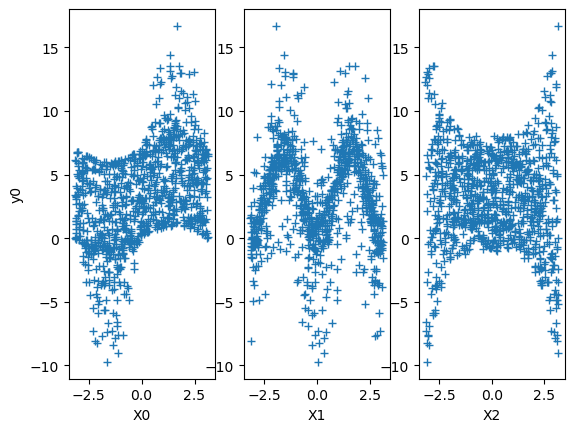

In [7]:
input_description = input_sample.getDescription()
output_description = output_sample.getDescription()
input_dimension = input_sample.getDimension()
_ = fig, axs = pl.subplots(1, input_dimension)
for i in range(input_dimension):
    _ = axs[i].plot(input_sample[:, i], output_sample[:, 0], "+")
    axs[i].set_xlabel(input_description[i])
_ = axs[0].set_ylabel(output_description[0])

## Cross-cuts of a function

### Using OpenTURNS only

In [8]:
m = WingWeightModel()
lowerBound = m.inputDistribution.getRange().getLowerBound()
upperBound = m.inputDistribution.getRange().getUpperBound()

nX = ot.ResourceMap.GetAsUnsignedInteger("Evaluation-DefaultPointNumber")
description = m.inputDistribution.getDescription()
description.add("")
m.model.setDescription(description)
m.model.setName("wing weight model")

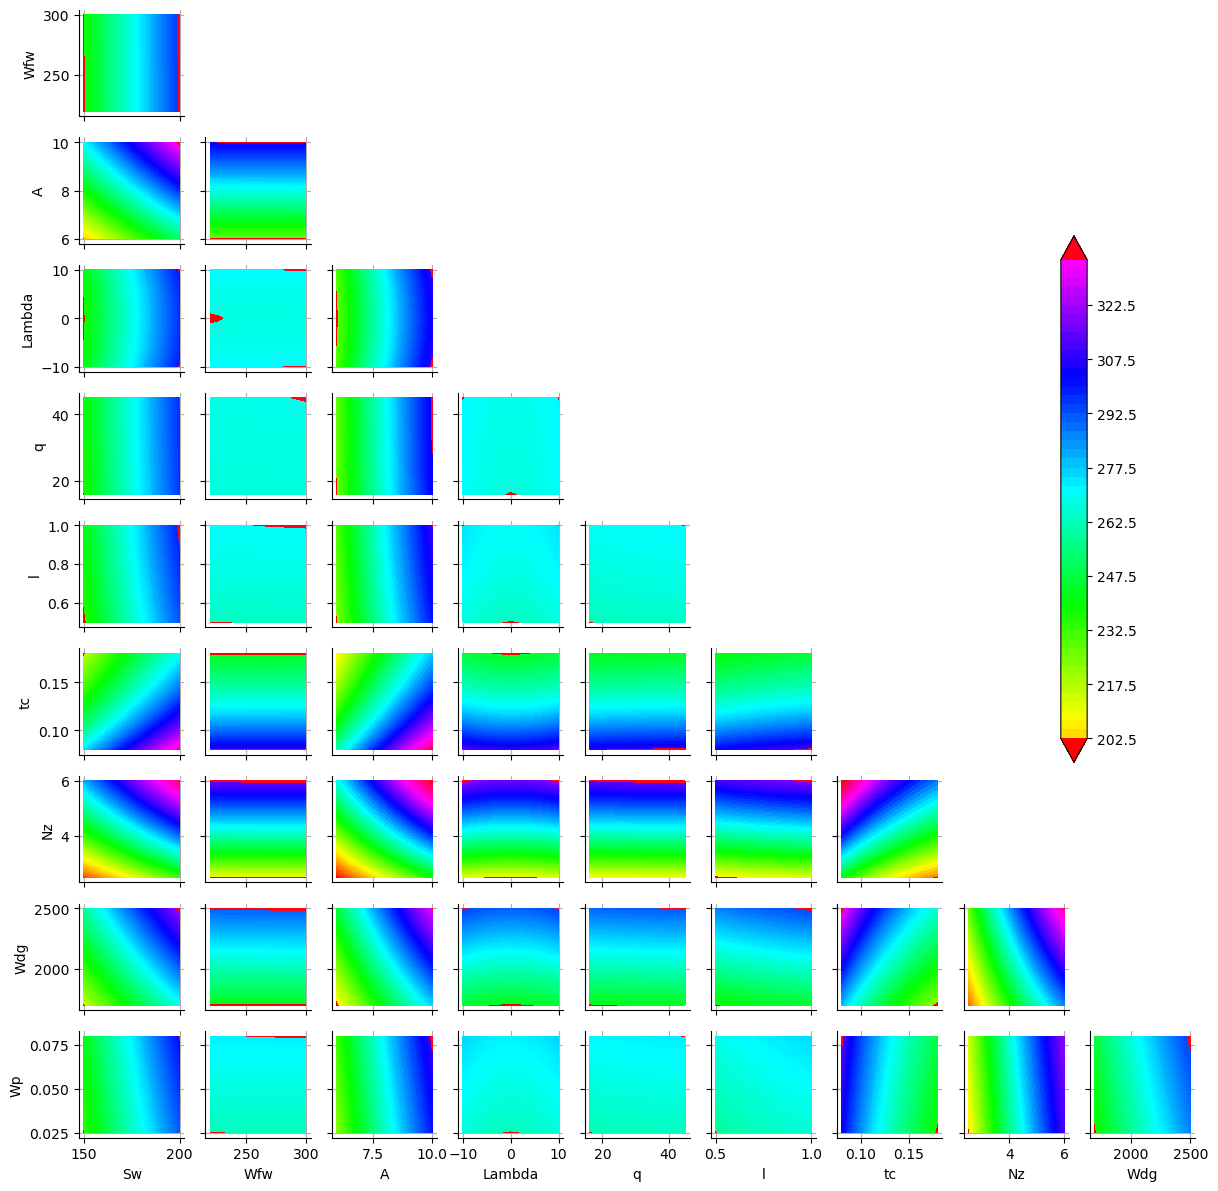

In [9]:
grid = m.model.drawCrossCuts(  # <-- This is the tested feature
    m.inputDistribution.getMean(),
    lowerBound,
    upperBound,
    [nX] * m.model.getInputDimension(),
    False,
    True,
    176.0,
    363.0,
)
grid.setTitle("")
# Get View object to manipulate the underlying figure
# Here we decide the colormap and the number of levels used for all contours
view = otv.View(grid, contour_kw={"cmap": "hsv", "levels": 55})

axes = view.getAxes()
fig = view.getFigure()
fig.set_size_inches(12, 12)  # reduce the size

# Setup a large colorbar
fig.colorbar(
    view.getSubviews()[1][0].getContourSets()[0], ax=axes[:-2, -1], fraction=0.3
)
# Hide unwanted axes labels
for i in range(len(axes)):
    for j in range(i + 1):
        if i < len(axes) - 1:
            axes[i][j].xaxis.set_ticklabels([])
        if j > 0:
            axes[i][j].yaxis.set_ticklabels([])
fig.subplots_adjust(top=0.99, bottom=0.05, left=0.06, right=0.99)

### Using Matplotlib, if OpenTURNS had no drawCrossCuts()

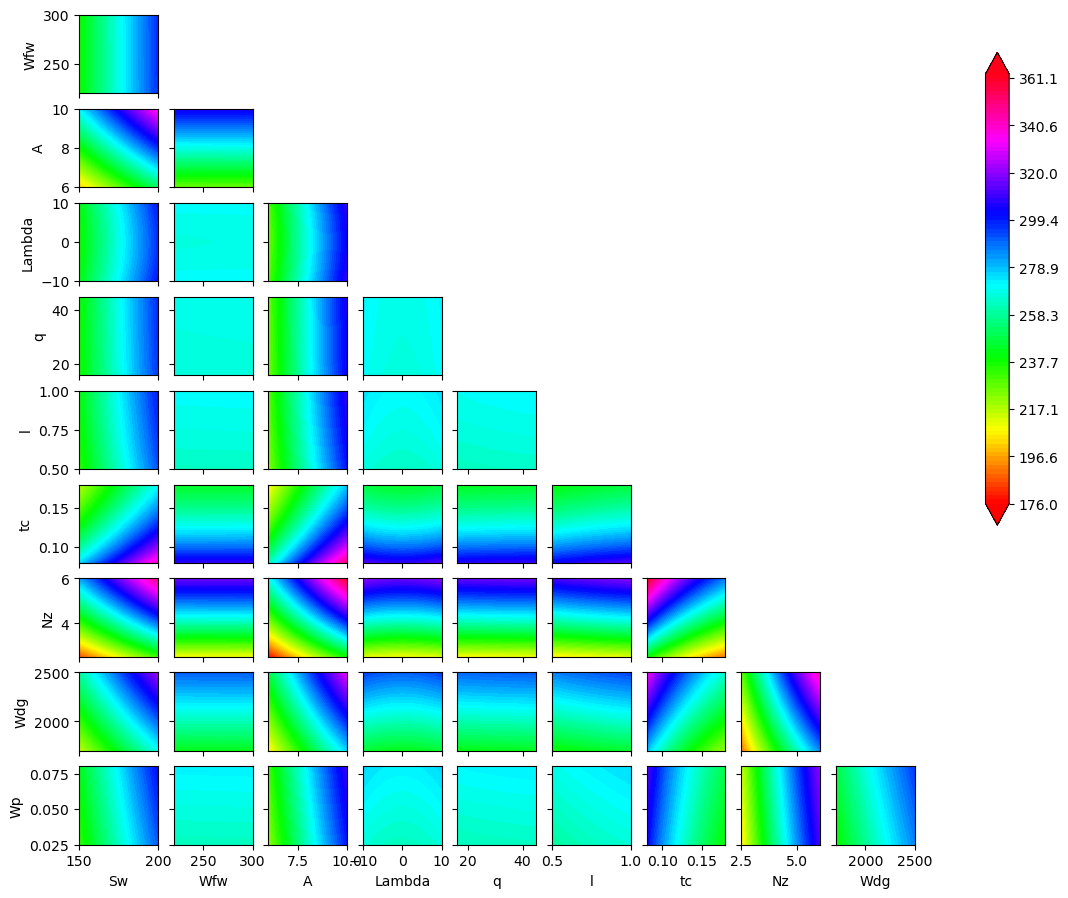

In [ ]:
fig, axes = pl.subplots(m.dim, m.dim, figsize=(12, 12))
levels = np.linspace(176.0, 363.0, 101)

# Definition of number of meshes in x and y axes for the 2D cross cut plots
for i in range(m.dim):
    for j in range(i, m.dim):
        axes[i, j].set_visible(False)
    for j in range(i):
        crossCutIndices = []
        crossCutReferencePoint = []
        for k in range(m.dim):
            if k != i and k != j:
                crossCutIndices.append(k)
                # Definition of the reference point
                crossCutReferencePoint.append(m.inputDistribution.getMean()[k])
        # Definition of 2D cross cut function
        crossCutFunction = ot.ParametricFunction(
            m.model, crossCutIndices, crossCutReferencePoint
        )
        crossCutLowerBound = [lowerBound[j], lowerBound[i]]
        crossCutUpperBound = [upperBound[j], upperBound[i]]
        # Definition of the mesh
        inputData = ot.Box([nX, nX]).generate()
        inputData *= ot.Point(crossCutUpperBound) - ot.Point(crossCutLowerBound)
        inputData += ot.Point(crossCutLowerBound)
        meshX = np.array(inputData)[:, 0].reshape(nX + 2, nX + 2)
        meshY = np.array(inputData)[:, 1].reshape(nX + 2, nX + 2)
        data = crossCutFunction(inputData)  # Vectorized
        meshZ = np.array(data).reshape(nX + 2, nX + 2)

        # Creation of the contour
        index = 1 + i * m.dim + j

        ax = axes[i, j]
        # Need to save the reference contour for the colorbar
        if i == 1 and j == 0:
            special_contour = ax.contourf(
                meshX,
                meshY,
                meshZ,
                cmap="hsv",
                vmin=176.0,
                vmax=363.0,
                levels=levels,
                extend="both",
            )
        else:
            ax.contourf(
                meshX, meshY, meshZ, cmap="hsv", vmin=176.0, vmax=363.0, levels=levels
            )

        # Creation of axes title
        if j == 0:
            ax.set_ylabel(m.inputDistribution.getDescription()[i])
        if i == 9:
            ax.set_xlabel(m.inputDistribution.getDescription()[j])

# Setup a large colorbar
fig.colorbar(special_contour, ax=axes[:-2, -1], fraction=0.3)

# Hide unwanted axes labels
for i in range(len(axes)):
    for j in range(i + 1):
        if i < len(axes) - 1:
            axes[i, j].xaxis.set_ticklabels([])
        if j > 0:
            axes[i, j].yaxis.set_ticklabels([])

## Contour of the PDF of a distribution

### Using OpenTURNS only

In [11]:
corr = ot.CorrelationMatrix(2)
corr[0, 1] = 0.2
copula = ot.NormalCopula(corr)
x1 = ot.Normal(-1.0, 1)
x2 = ot.Normal(2, 1)
x_funk = ot.JointDistribution([x1, x2], copula)

x1 = ot.Normal(1.0, 1)
x2 = ot.Normal(-2, 1)
x_punk = ot.JointDistribution([x1, x2], copula)
mixture = ot.Mixture([x_funk, x_punk], [0.5, 1.0])

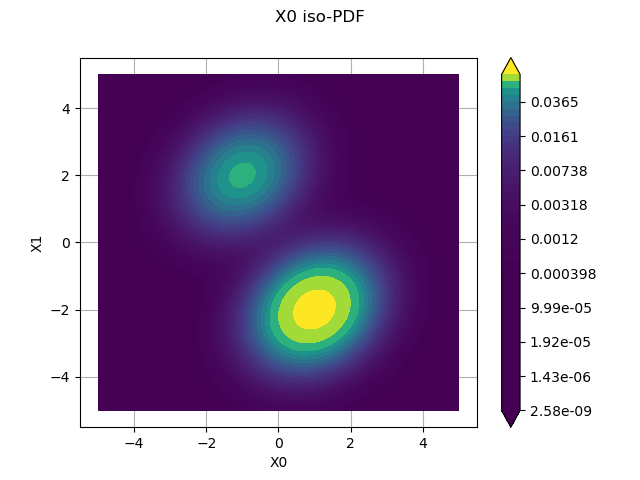

In [12]:
ot.ResourceMap.SetAsBool("Contour-DefaultIsFilled", True)
ot.ResourceMap.SetAsUnsignedInteger("Contour-DefaultLevelsNumber", 50)

graph = mixture.drawPDF([-5.0, -5.0], [5.0, 5.0])  # <-- This is the tested feature
graph

### Using Matplotlib, if OpenTURNS had no 2D Distribution.drawPDF()

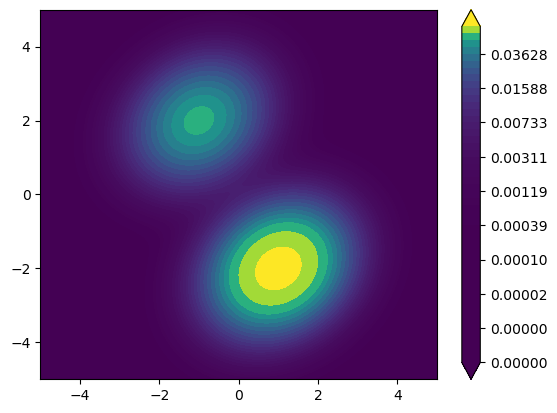

In [ ]:
# Create the input mesh
lowerBound = [-5.0, -5.0]
upperBound = [5.0, 5.0]
numberOfXCells = 100
numberOfYCells = 100
xList = np.linspace(lowerBound[0], upperBound[0], numberOfXCells)
yList = np.linspace(lowerBound[1], upperBound[1], numberOfYCells)
xArray, yArray = np.meshgrid(xList, yList)
# Convert to Sample
xArrayFlat = xArray.flatten()
yArrayFlat = yArray.flatten()
size = numberOfXCells * numberOfYCells
inputSample = ot.Sample(size, 2)
inputSample[:, 0] = ot.Sample.BuildFromPoint(xArrayFlat)
inputSample[:, 1] = ot.Sample.BuildFromPoint(yArrayFlat)
# Evaluate the function
zArray = mixture.computePDF(inputSample)  # Vectorized
zArray = np.array(zArray)
zArray = zArray.transpose()
zArray = np.reshape(zArray, (numberOfYCells, numberOfXCells))
# Compute levels
epsilonGrid = 1.0e-2
numberOfLevels = 50
zSample = ot.Sample.BuildFromPoint(zArray.flatten())
regularGrid = np.linspace(epsilonGrid, 1.0 - epsilonGrid, numberOfLevels)
levelsSample = zSample.computeQuantile(regularGrid)
levels = [point[0] for point in levelsSample]
fig, ax = pl.subplots(1, 1)
cp = ax.contourf(xArray, yArray, zArray, levels, cmap=mpl.cm.viridis, extend="both")
_ = fig.colorbar(cp)

### With OpenTURNS, letting Matplotlib choose the levels

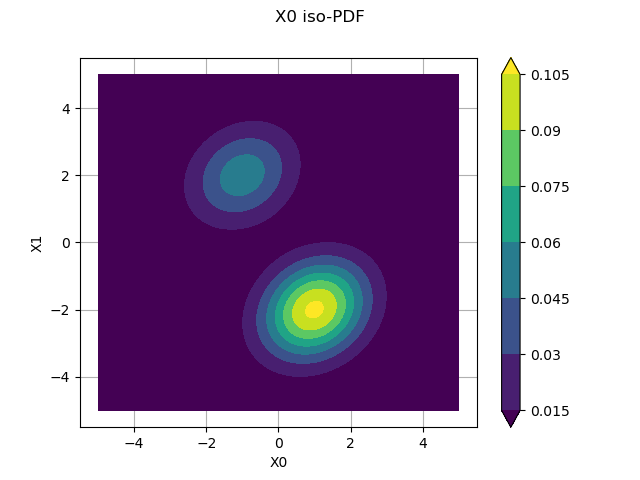

In [14]:
ot.ResourceMap.SetAsBool("Contour-DefaultIsFilled", True)

graph = mixture.drawPDF([-5.0, -5.0], [5.0, 5.0])  # <-- This is the tested feature
contour = graph.getDrawable(0).getImplementation()
contour.setLevels([])
graph.setDrawable(contour, 0)
graph

### With simple Matplotlib

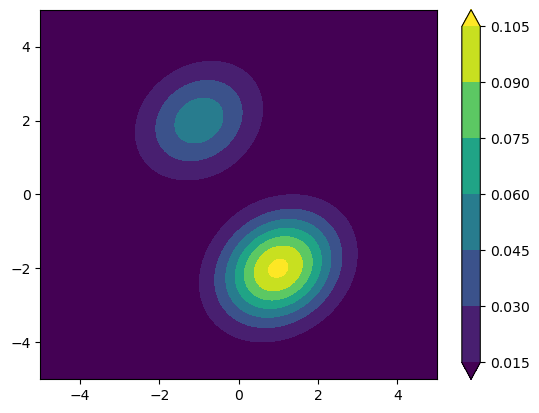

In [ ]:
# Create the input mesh
lowerBound = [-5.0, -5.0]
upperBound = [5.0, 5.0]
numberOfXCells = 100
numberOfYCells = 100
xList = np.linspace(lowerBound[0], upperBound[0], numberOfXCells)
yList = np.linspace(lowerBound[1], upperBound[1], numberOfYCells)
xArray, yArray = np.meshgrid(xList, yList)
# Convert to Sample
xArrayFlat = xArray.flatten()
yArrayFlat = yArray.flatten()
size = numberOfXCells * numberOfYCells
inputSample = ot.Sample(size, 2)
inputSample[:, 0] = ot.Sample.BuildFromPoint(xArrayFlat)
inputSample[:, 1] = ot.Sample.BuildFromPoint(yArrayFlat)
# Evaluate the function
zArray = mixture.computePDF(inputSample)  # Vectorized
zArray = np.array(zArray)
zArray = zArray.transpose()
zArray = np.reshape(zArray, (numberOfYCells, numberOfXCells))
fig, ax = pl.subplots(1, 1)
_ = cp = ax.contourf(xArray, yArray, zArray, cmap=mpl.cm.viridis, extend="both")
_ = fig.colorbar(cp)

## Sobol' indices of a function

In [16]:
im = ishigami_function.IshigamiModel()
input_names = im.inputDistribution.getDescription()
size = 1000
sie = ot.SobolIndicesExperiment(im.inputDistribution, size)
inputDesign = sie.generate()
input_names = im.inputDistribution.getDescription()
inputDesign.setDescription(input_names)
inputDesign.getSize()
outputDesign = im.model(inputDesign)
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

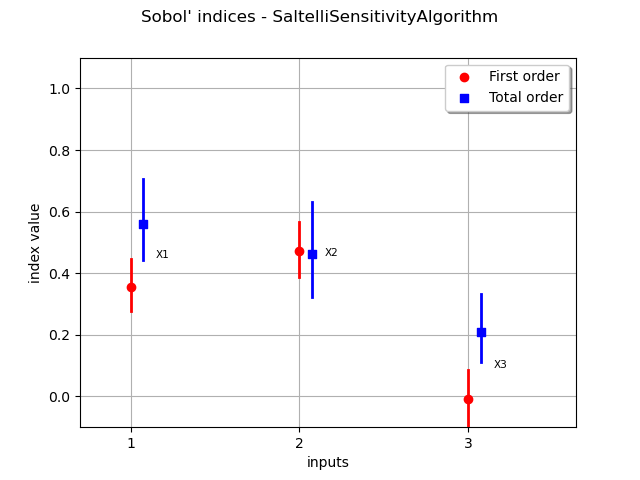

In [17]:
graph = sensitivityAnalysis.draw()  # <-- This is the tested feature
graph

### Using Matplotlib, if OpenTURNS had no SaltelliSensitivityAlgorithm.draw()

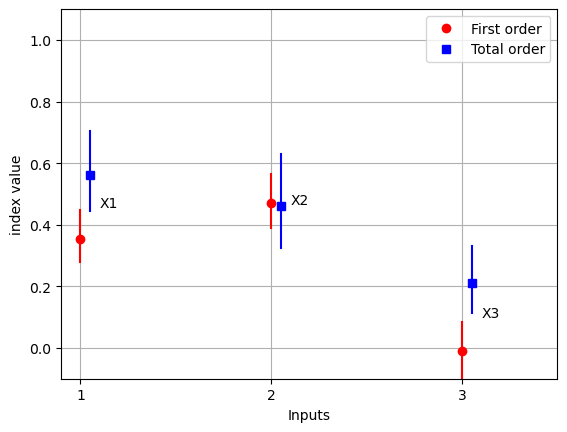

In [18]:
first_order_indices = sensitivityAnalysis.getFirstOrderIndices()
total_order_indices = sensitivityAnalysis.getTotalOrderIndices()
input_dimension = im.inputDistribution.getDimension()
fig = pl.figure()
input_indices = range(1, 1 + input_dimension)
pl.plot(input_indices, first_order_indices, "ro", label="First order")
delta_x = 0.05
shifted_indices = [1 + i + delta_x for i in range(input_dimension)]
pl.plot(shifted_indices, total_order_indices, "bs", label="Total order")
pl.legend()
pl.ylim(-0.1, 1.1)
pl.grid()
ax = pl.gca()  # Get the current axes
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
pl.xlabel("Inputs")
confidenceLevel = 0.95
first_order_distribution = sensitivityAnalysis.getFirstOrderIndicesDistribution()
total_order_distribution = sensitivityAnalysis.getTotalOrderIndicesDistribution()
description = im.inputDistribution.getDescription()
for i in range(input_dimension):
    # First order
    marginal_first_order_distribution = first_order_distribution.getMarginal(i)
    marginal_interval = (
        marginal_first_order_distribution.computeBilateralConfidenceInterval(
            confidenceLevel
        )
    )
    first_order_lower_bound = marginal_interval.getLowerBound()[0]
    first_order_uper_bound = marginal_interval.getUpperBound()[0]
    pl.plot([1 + i, 1 + i], [first_order_lower_bound, first_order_uper_bound], "r-")
    # Total order
    marginal_total_order_distribution = total_order_distribution.getMarginal(i)
    marginal_interval = (
        marginal_total_order_distribution.computeBilateralConfidenceInterval(
            confidenceLevel
        )
    )
    total_order_lower_bound = marginal_interval.getLowerBound()[0]
    total_order_uper_bound = marginal_interval.getUpperBound()[0]
    pl.plot(
        [1 + i + delta_x, 1 + i + delta_x],
        [total_order_lower_bound, total_order_uper_bound],
        "b-",
    )
    # Label
    vertical_location = 0.5 * (first_order_indices[i] + total_order_indices[i])
    pl.text(1 + i + 2 * delta_x, vertical_location, description[i])
_ = pl.ylabel("index value")
_ = pl.xlim(0.9, input_dimension + 0.5)

## Conclusion

In this Notebook, we have seen that the `draw()` methods of a `Function` or a `Distribution` can be used to plot it. This is in contrast with Matplotlib, which _does not have these objects_. Hence, the plotting library must consider only lists or arrays of floating point numbers. Therefore, the user has to first produce the values and give them to Matplotlib. Matplotlib does not know the content of the data that is plotted. Instead, OpenTURNS knows that the data to plot is a `Function` or a `Distribution`. For example, the `drawPDF()` method can use the quantile function to define the bounds used in the plot.

We often have to use very specific Numpy or OpenTURNS methods to build these plots. For example, the cross-cut of a function must use `np.meshgrid` to produce the X and Y values. This is mandatory in order to get a vectorized code that has a minimum performance. Otherwise, two nested loops would be required, which would be much slower (test it and see the difference). Another example is the plot of Sobol' indices associated with confidence intervals. In this case, we first use `getFirstOrderIndicesDistribution()` in order to get the distribution, then compute a bilateral confidence interval using `computeBilateralConfidenceInterval()`. Some users may not find these methods and may struggle to produce these plots with a script having the required performance.

Since Matplotlib is not dedicated to Uncertainty Quantification, it does not produce the specific plots that we are often interested in when working in this field. For example, there is no built-in feature to produce a QQ-plot or a surrogate validation plot in Matplotlib, which are relatively common in UQ. Moreover, Matplotlib does not have specific features to manage probabilities, probability density functions or Sobol' indices. For example, the plot of Sobol' indices requires to customize the Y axis from 0 to 1 (and add an extra space for the margin), since these indices are in the [0,1] interval.

All in all, many scripts using Matplotlib only are much longer than their pure Matplotlib counterpart. On the other hand, OpenTURNS does not provide the level of flexibility that Matplotlib has. This is why we often have to customize the plot produced by OpenTURNS. This can be done using `Viewer.getFigure()` which returns Matplotlib's object. Depending on the level of fine-tuning that we are interested in, this can also be done by creating a Matplotlib from scratch. In many cases, however, the plot produced by OpenTURNS is usable and is a good starting point.

## See also
- DrawParallelCoordinates (good luck !)
- DrawQQplot
- DrawKendallPlot
- DrawHenryLine
- PlotDesign